# ART for scikit-learn LogisticRegression

In [1]:
from sklearn.linear_model import LogisticRegression

import numpy as np
from matplotlib import pyplot as plt

from art.classifiers import SklearnLogisticRegression
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.utils import load_mnist

# Load and transform MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 100
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

# Train LogisticRegression classifier

In [3]:
skl_lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='warn', verbose=0, warm_start=False, n_jobs=None)

In [4]:
skl_lr.fit(X=x_train, y=y_train)

/home/bbuesser/venv36/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Create and apply ProjectedGradientDescent Attack with ART

In [5]:
art_lr = SklearnLogisticRegression(model=skl_lr)

In [6]:
pgd = ProjectedGradientDescent(classifier=art_lr, norm=np.inf, eps=.3, eps_step=0.1, max_iter=20, targeted=False, num_random_init=0,
                 batch_size=128)

In [7]:
x_train_adv = pgd.generate(x_train)

In [8]:
x_test_adv = pgd.generate(x_test)

# Evaluate LogisticRegression classifier on benign and adversarial samples

In [9]:
score = skl_lr.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


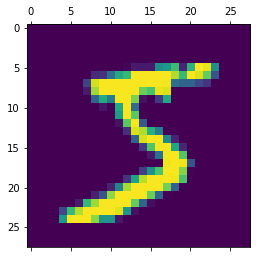

In [10]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [11]:
prediction = skl_lr.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [12]:
score = skl_lr.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.4600


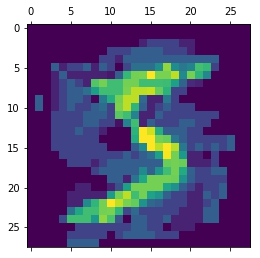

In [13]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [14]:
prediction = skl_lr.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 3


In [15]:
score = skl_lr.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7300


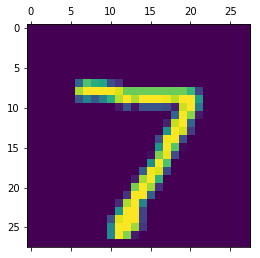

In [16]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [17]:
prediction = skl_lr.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [18]:
score = skl_lr.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.1500


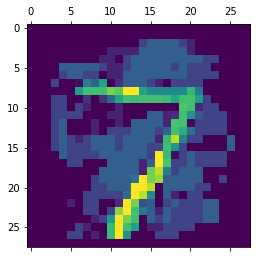

In [19]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [20]:
prediction = skl_lr.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 9


# Investigate dependence on attack budget eps

(0, 1)

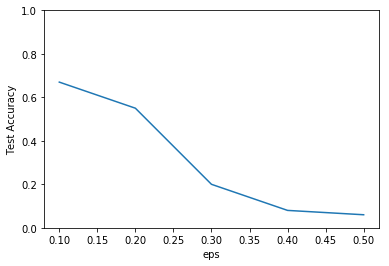

In [21]:
eps_list = [0.1, 0.2, 0.3, 0.4, 0.5]
score_list = list()

for eps in eps_list:
    pgd = ProjectedGradientDescent(classifier=art_lr, norm=np.inf, eps=eps, eps_step=0.05, max_iter=20, targeted=False, num_random_init=0,
                 batch_size=128)
    x_test_adv = pgd.generate(x_test)
    score = skl_lr.score(x_test_adv, y_test)
    score_list.append(score)

plt.plot(eps_list, score_list)
plt.xlabel('eps')
plt.ylabel('Test Accuracy')
plt.ylim((0, 1))